In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61406 sha256=bb2d80e40ad808bb083ffc9fb8b10a64ac00a2e2570e45adcdf5a5b44d885970
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=c3287329a8764b66ab21b5ae4e8008ad7b6f9643090444663ae5e9beb477f86e
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 117.2 MB/s eta 0:00:00


In [4]:
import torch
from pytorch3d.io import load_obj, save_obj, load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    SoftPhongShader,
    MeshRasterizer,
    TexturesUV,
    TexturesAtlas
)
from torchvision.utils import make_grid

import numpy as np

from tqdm.notebook import tqdm

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['savefig.dpi']=80
# mpl.rcParams['figure.dpi']=80

if torch.cuda.is_available():
  device=torch.device("cuda:0")
else:
  device=torch.device('cpu')
  print('cannot find gpu')



In [5]:
!pwd

/content


In [6]:
!ls

drive  sample_data


In [7]:
import os
os.chdir('drive/MyDrive/Colab Notebooks')

In [8]:
!ls

data  Untitled0.ipynb


In [9]:
!ls

data  Untitled0.ipynb


In [17]:


# for case, where input a obj file
DATA_DIR= "./data"
obj_file=os.path.join(DATA_DIR, "cow_mesh/cow.obj")


verts,faces,aux=load_obj(
    obj_file,
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
)

# so this load_textures=True and create)texture_atlas=Trye, this will be a FloatTensor of this form:
# (F,texture_size,texture_size,3),then all faces will have a uniform white texture

#this line works for multiple texture
mesh=Meshes(verts=[verts], faces=[faces.verts_idx], textures=TexturesAtlas(atlas=[aux.texture_atlas]))



/usr/local/lib/python3.10/dist-packages/pytorch3d/io/mtl_io.py:102: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


In [ ]:
# #only for when using load_objs_as_meshes

# plt.figure(figsize=(5,5))

# texturesuv_image_matplotlib(mesh.textures, subsample=None)
# plt.axis("off");

2. create a renderer and rendering

In [18]:
R, T = look_at_view_transform(15,60,90)

cameras=FoVPerspectiveCameras(device=device, R=R, T=T)

raster_settings=RasterizationSettings(
    image_size=1080,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights=PointLights(device=device, location=[[0.0,0.0,5]] )

renderer=MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras,
                              raster_settings=raster_settings),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
    )

)

#camera, lights has device, rasterizer doesnt have because it is cuda based, shader also have

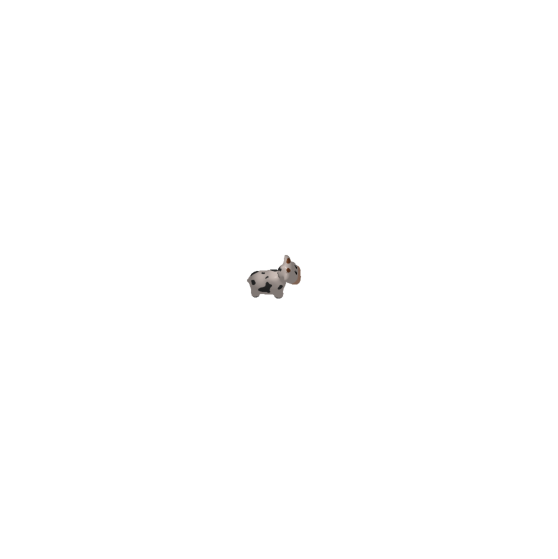

In [19]:
#now lets do rendering

images=renderer(mesh)
plt.figure(figsize=(7,7))

# print(images.shape)
cpu_images=images[0,...,:3].cpu().numpy()

plt.imshow(cpu_images)
plt.axis("off");


In [1]:


# #just for making sure it has more viewpoint
# num_view=4

# meshes=mesh.extend(num_view)

# elev=torch.linspace(0,360, num_view)
# azim=torch.linspace(-180,180, num_view)

# R,T= look_at_view_transform(dist=5, elev=elev, azim=azim)
# camera=FoVPerspectiveCameras(device=device, R=R, T=T)

# images=renderer(meshes, cameras=camera)




NameError: ignored

In [18]:
#use matplotlib to print

# import torch
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Assuming you've already created the 'point_cloud' tensor
# # Sample point cloud shape: (B, N, 3)
# point_cloud = sample_points_from_meshes(mesh, 3000)

# # Extract the point cloud data
# point_cloud = point_cloud[0].cpu().numpy()  # Assuming one point cloud in the batch

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot the points
# ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=1)

# # Set labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# plt.show()




[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
